# Covid Brasil

In [2]:
#%config IPCompleter.greedy=True
#!pip install pandas
#!pip install seaborn
#!pip install plotly
#!pip install altair

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt 
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import altair as alt
print('Modules are imported.')

Modules are imported.


In [4]:
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff

In [5]:
import io
import requests
url='https://data.brasil.io/dataset/covid19/caso.csv.gz'
s=requests.get(url).content


In [6]:
with open('data/covidio.csv.gz', 'wb') as f:
    f.write(s)

In [7]:
#df = pd.read_csv('data/covidio.csv.gz', parse_dates=['last_available_date'], index_col='last_available_date')
df = pd.read_csv('data/covidio.csv.gz')


In [8]:
df.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2021-06-07,AP,NaN,state,113139,1727,441,True,845731.0,861773.0,16.0,13128.63132,0.0153
1,2021-06-06,AP,NaN,state,112999,1719,440,False,845731.0,861773.0,16.0,13112.38574,0.0152
2,2021-06-05,AP,NaN,state,112878,1718,439,False,845731.0,861773.0,16.0,13098.34492,0.0152
3,2021-06-04,AP,NaN,state,112782,1716,438,False,845731.0,861773.0,16.0,13087.20510,0.0152
4,2021-06-03,AP,NaN,state,112654,1712,437,False,845731.0,861773.0,16.0,13072.35200,0.0152


In [9]:
df['mortalidade'] =  df['deaths']/df['estimated_population']
df['mortalidade100k'] = (df['deaths']*100000)/df['estimated_population']
df[['mortalidade', 'death_rate', 'mortalidade100k']].head()

,mortalidade,death_rate,mortalidade100k
0,0.002004,0.0153,200.400802
1,0.001995,0.0152,199.472483
2,0.001994,0.0152,199.356443
3,0.001991,0.0152,199.124363
4,0.001987,0.0152,198.660204


In [10]:
df.drop(df[df['deaths'] == 0].index, inplace=True)

In [11]:
df_states = df[(df['is_last'] == True) &(df.place_type=='state')][['state','confirmed','deaths', 'death_rate','mortalidade','mortalidade100k']]
df_cities = df[(df['is_last'] == True) &(df.place_type=='city')][['city','state', 'confirmed','deaths', 'death_rate','mortalidade','mortalidade100k']]

In [12]:
# deletando linhas inuteis
df_cities.drop(df_cities[df_cities['city'] == 'Importados/Indefinidos'].index, inplace=True)

In [13]:
df_states.columns = ['Estado', 'Confirmados', 'Mortes', 'Letalidade','Mortalidade', 'Mortalidade100k']
df_cities.columns = ['Cidade', 'Estado', 'Confirmados', 'Mortes', 'Letalidade','Mortalidade', 'Mortalidade100k']

<AxesSubplot:ylabel='Frequency'>

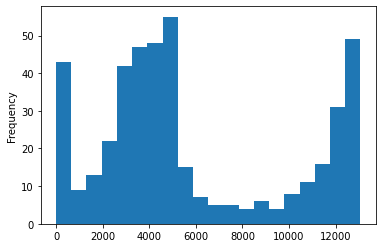

In [14]:
df[(df.place_type=='state') &(df.state == 'AM')].sort_values('date').set_index('date')['deaths'].plot(
    kind='hist',
    bins=20,
    title='')

In [15]:
df_states[df_states['Estado'] == 'MA']

,Estado,Confirmados,Mortes,Letalidade,Mortalidade,Mortalidade100k
275077,MA,295218,8331,0.0282,0.001171,117.09727


In [16]:
#df_cities.sort_values('Letalidade',ascending=False).head()
df_states['Ltemp'] =  df_states['Letalidade'] * 100
df_states['Letalidade_rank'] = df_states['Ltemp'].astype(int).rank(method='dense')
df_states['Mortalidade_rank'] = df_states['Mortalidade'].rank(method='dense')
df_states['rank'] = ((df_states['Mortalidade_rank'] + df_states['Letalidade_rank'])/2).rank(method='dense').astype(int)
df_cities['Ltemp'] =  df_cities['Letalidade'] * 100
df_cities['Letalidade_rank'] = df_cities['Ltemp'].rank(method='dense').astype(int)
df_cities['Mortalidade_rank'] = df_cities['Mortalidade'].rank(method='dense').astype(int)
df_cities['rank'] = ((df_cities['Mortalidade_rank'] + df_cities['Letalidade_rank'])/2).rank(method='dense').astype(int)

In [17]:
df_states.sort_values('rank', ascending=True).head(10)

,Estado,Confirmados,Mortes,Letalidade,Mortalidade,Mortalidade100k,Ltemp,Letalidade_rank,Mortalidade_rank,rank
275077,MA,295218,8331,0.0282,0.001171,117.097270,2.82,2.0,1.0,1
42871,AL,198440,4880,0.0246,0.001456,145.604577,2.46,2.0,2.0,2
879037,BA,1037924,21829,0.0210,0.001462,146.202767,2.10,2.0,3.0,3
362574,PA,525675,14764,0.0281,0.001699,169.881869,2.81,2.0,4.0,4
479968,RN,275370,6295,0.0229,0.001781,178.118452,2.29,2.0,6.0,5
1239696,TO,182924,2953,0.0161,0.001857,185.694307,1.61,1.0,7.0,5
1980190,PE,500821,16357,0.0327,0.001701,170.090929,3.27,3.0,5.0,5
1893876,PI,279709,6116,0.0219,0.001864,186.379317,2.19,2.0,8.0,6
6756,AC,83350,1692,0.0203,0.001892,189.162297,2.03,2.0,9.0,7
1811582,PB,345596,7883,0.0228,0.001952,195.158688,2.28,2.0,10.0,8


In [18]:
df_states['Letalidade'].mean() * 100

2.5225925925925923

In [19]:
df_cities['Letalidade'].mean()

0.024392281147838722

In [20]:
df.columns

Index(['date', 'state', 'city', 'place_type', 'confirmed', 'deaths',
       'order_for_place', 'is_last', 'estimated_population_2019',
       'estimated_population', 'city_ibge_code',
       'confirmed_per_100k_inhabitants', 'death_rate', 'mortalidade',
       'mortalidade100k'],
      dtype='object')

In [21]:
def search_city(city, color='red', reverse=False):
    return df_cities[df['city'] == city]

def style_frame(df):
    cm = sns.light_palette(color, as_cmap=True, reverse=reverse)
    return (df.style.set_properties(**{'text-align': 'right'}).background_gradient(cmap=cm).hide_index()).set_caption(
    title)

def treemap_show(df=df_states, nivel='Estado', column='rank', n=10,  asc=False, title=""):
    fig = px.treemap(df.head(30), 
                 path=[nivel], 
                 values=column, height=700,
                 title=title,
                 color_discrete_sequence = px.colors.qualitative.Prism)

    fig.data[0].textinfo = 'label+text+value'
    #fig.write_image("images/fig2.png")

    fig.show()


def covid_data_table(df, nivel, column, n, asc=False,title="", color='red', reverse=False, corte=0):

    if(corte > 0):
        df = df[df['Mortes'] > corte]
    
    df = df.sort_values(column,ascending=asc).copy().head(n)

    data_table = pd.DataFrame()
    data_table[nivel] = df[nivel]
    if nivel == 'Cidade':
        data_table['Estado'] = df['Estado']
    #data_table["Confirmados"] = df['Confirmados']
    data_table["rank"] = df['rank']
    data_table["Letalidade_rank"] = df['Letalidade_rank']
    data_table["Mortalidade_rank"] = df['Mortalidade_rank']
    data_table["Mortes"] = df['Mortes']
    data_table["Mortalidade100k"] = df['Mortalidade100k'].astype(int)
    data_table["LetPerc"] = df["Ltemp"]
    data_table["Letalidade"] = df['Letalidade']
    
    #data_table["Mortalidade"] = df['Mortalidade']
    
    cm = sns.light_palette(color, as_cmap=True, reverse=reverse)
    return (data_table.style.set_properties(**{'text-align': 'right'}).background_gradient(cmap=cm).hide_index()).set_caption(
    title)

def tabela_estado(column, n, asc=False,title="", color='red', reverse=False, corte=0):
    '''Retorna uma table para estado '''
    return covid_data_table(df_states,'Estado', column, n, asc=asc,title=title, color=color, reverse=reverse, corte=corte)

def tabela_estado_reversa(column, n, title="", corte=0):
    return tabela_estado(column, n, True, title, 'green', True, corte)

def tabela_cidade(column, n, asc=False,title="", color='red', reverse=False, corte=0):
    '''Retorna uma table para cidades '''
    return covid_data_table(df_cities,'Cidade', column, n, asc=asc,title=title, color=color, reverse=reverse, corte=corte)

def tabela_cidade_reversa(column, n, title="", corte=0):
    return tabela_cidade(column, n, True, title, 'green', True, corte=corte)

## Piores no Ranking (Letalidade %)

In [22]:
tabela_estado('Letalidade', 20)

Estado,rank,Letalidade_rank,Mortalidade_rank,Mortes,Mortalidade100k,LetPerc,Letalidade
RJ,19,4.000000,24.000000,51540,296,5.820000,0.058200
SP,15,3.000000,18.000000,114542,247,3.400000,0.034000
AM,19,3.000000,25.000000,13063,310,3.350000,0.033500
PE,5,3.000000,5.000000,16357,170,3.270000,0.032700
GO,14,2.000000,17.000000,17572,247,2.820000,0.028200
MA,1,2.000000,1.000000,8331,117,2.820000,0.028200
PA,4,2.000000,4.000000,14764,169,2.810000,0.028100
MT,19,2.000000,26.000000,11209,317,2.680000,0.026800
RS,15,2.000000,19.000000,28866,252,2.580000,0.025800
MG,9,2.000000,11.000000,41673,195,2.570000,0.025700


## Melhores Estados por letalidade

In [23]:
tabela_estado_reversa('Letalidade',20)

Estado,rank,Letalidade_rank,Mortalidade_rank,Mortes,Mortalidade100k,LetPerc,Letalidade
AP,9,1.000000,12.000000,1727,200,1.530000,0.015300
RR,16,1.000000,21.000000,1651,261,1.570000,0.015700
SC,10,1.000000,13.000000,15663,215,1.590000,0.015900
TO,5,1.000000,7.000000,2953,185,1.610000,0.016100
AC,7,2.000000,9.000000,1692,189,2.030000,0.020300
BA,3,2.000000,3.000000,21829,146,2.100000,0.021000
DF,18,2.000000,23.000000,8826,288,2.140000,0.021400
SE,11,2.000000,14.000000,5246,226,2.140000,0.021400
PI,6,2.000000,8.000000,6116,186,2.190000,0.021900
ES,17,2.000000,22.000000,11005,270,2.240000,0.022400


## Top  20 piores cidades do brasil com +500 Obitos

In [24]:
tabela_cidade('Letalidade',20, corte=500)

Cidade,Estado,rank,Letalidade_rank,Mortalidade_rank,Mortes,Mortalidade100k,LetPerc,Letalidade
São João de Meriti,RJ,2799,640,3903,1009,213,10.880000,0.108800
Petrópolis,RJ,3505,636,5204,1162,378,10.500000,0.105000
Nova Iguaçu,RJ,2493,622,3415,1531,185,8.910000,0.089100
Viamão,RS,3099,617,4422,648,252,8.140000,0.081400
Rio de Janeiro,RJ,3507,615,5239,26689,395,8.050000,0.080500
Guarulhos,SP,3321,601,4790,4018,288,7.390000,0.073900
Paulista,PE,2739,599,3842,703,210,7.260000,0.072600
Itaboraí,RJ,3244,583,4681,672,277,6.830000,0.068300
Duque de Caxias,RJ,1948,568,2611,1380,149,6.510000,0.065100
São Vicente,SP,3142,545,4565,976,264,6.050000,0.060500


## Top 20 Cidades do Brasil

In [25]:
tabela_cidade_reversa('Letalidade',20,corte=500)

Cidade,Estado,rank,Letalidade_rank,Mortalidade_rank,Mortes,Mortalidade100k,LetPerc,Letalidade
Blumenau,SC,1638,93,2602,539,148,1.120000,0.011200
Palmas,TO,1960,105,3094,523,170,1.240000,0.012400
Florianópolis,SC,2245,111,3529,985,193,1.300000,0.013000
Criciúma,SC,2712,134,4260,518,238,1.530000,0.015300
Boa Vista,RR,3094,140,4890,1266,301,1.590000,0.015900
Dourados,MS,2668,140,4179,523,231,1.590000,0.015900
Joinville,SC,2782,143,4372,1486,248,1.620000,0.016200
São José,SC,2528,145,3960,542,216,1.640000,0.016400
Vitória da Conquista,BA,1656,147,2575,505,148,1.660000,0.016600
Passo Fundo,RS,2800,156,4388,512,250,1.750000,0.017500


## Top 10 menor letalidade 

In [26]:
def covid_bubble_chart(df, column, n, asc=False):
    df = df.sort_values(column,ascending=asc).copy().head(n)
    fig = px.scatter(df, x="Estado", y=column, size=column, color="Estado",
               text="Estado", size_max=90)
    fig.update_layout(
    title="Os top " + str(n) + ' piores estados por '  + column,
    xaxis_title="Estados",
    yaxis_title=column,
    width = 700
    )
    fig.show();
    
covid_bubble_chart(df_states, 'Mortalidade100k',10, True)


In [27]:
covid_bubble_chart(df_states, 'Mortes',10)

In [28]:
search_city("Porto Feliz")

<ipython-input-21-ae56beb4e606>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Cidade,Estado,Confirmados,Mortes,Letalidade,Mortalidade,Mortalidade100k,Ltemp,Letalidade_rank,Mortalidade_rank,rank
1735971,Porto Feliz,SP,6255,97,0.0155,0.001816,181.641137,1.55,136,3328,2130
